In [1]:
import numpy as np
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
from matplotlib.pyplot import cm


%load_ext autoreload
%autoreload 2

In [6]:
tabular_str = """\
	conv4	convnext_base	resnet18	resnet50	swinv2	vit small	vit tiny
bigearthnet	0.5162 ± 0.0114	0.6918 ± 0.002	0.6786 ± 0.0023	0.6636 ± 0.0023	0.6997 ± 0.0027	0.7037 ± 0.0072	0.688 ± 0.0038
brick_kiln_v1.0	0.9377 ± 0.0055	0.9567 ± 0.0095	0.9523 ± 0.0091	0.9497 ± 0.0061	0.9627 ± 0.0064	0.9503 ± 0.0042	0.94 ± 0.0151
eurosat	0.8723 ± 0.0021	0.9843 ± 0.0021	0.9777 ± 0.0051	0.9757 ± 0.004	0.977 ± 0.0026	0.979 ± 0.0035	0.983 ± 0.006
pv4ger_classification	0.9107 ± 0.0071	0.9488 ± 0.0056	0.9469 ± 0.0081	0.9379 ± 0.0052	0.945 ± 0.0069	0.9461 ± 0.0053	0.9367 ± 0.0011
so2sat	0.2366 ± 0.0142	0.4922 ± 0.0188	0.4787 ± 0.0173	0.4662 ± 0.0038	0.5054 ± 0.0102	0.5331 ± 0.0079	0.5003 ± 0.0066"""

In [7]:
def get_mean(val):
    if "±" in val:
        return float(val.split("±")[0])
    else:
        return val

def get_std(val):
    if "±" in val:
        return float(val.split("±")[1])
    else:
        return val

df = pd.read_csv(StringIO(tabular_str), sep='\t', index_col=0)
df_mean = df.applymap(get_mean)
df_std = df.applymap(get_std)


df_mean


,conv4,convnext_base,resnet18,resnet50,swinv2,vit small,vit tiny
bigearthnet,0.5162,0.6918,0.6786,0.6636,0.6997,0.7037,0.6880
brick_kiln_v1.0,0.9377,0.9567,0.9523,0.9497,0.9627,0.9503,0.9400
eurosat,0.8723,0.9843,0.9777,0.9757,0.9770,0.9790,0.9830
pv4ger_classification,0.9107,0.9488,0.9469,0.9379,0.9450,0.9461,0.9367
so2sat,0.2366,0.4922,0.4787,0.4662,0.5054,0.5331,0.5003


In [8]:
class Normalizer:

    def __init__(self, df_mean, df_std, border=0.1):
        self.border = border
        self.range_dict = {}
        df_mean_t = df_mean.transpose()
        df_std_t = df_std.transpose()
        for ds_name in df_mean_t:
            mean = df_mean_t[ds_name].to_numpy()
            std = df_std_t[ds_name].to_numpy()

            self.range_dict[ds_name] = (min(mean-std), max(mean+std))
    
    def __call__(self, ds_name, values, scale_only=False):
        mn, mx = self.range_dict[ds_name]
        range = mx-mn
        if scale_only:
            return values / range
        else:
            return (values - mn)/range

    def from_row(self, row, scale_only=False):
        return [self(ds_name, val, scale_only=scale_only) for ds_name, val in row.items()]
        
        


conv4
convnext_base
resnet18
resnet50
swinv2
vit small
vit tiny


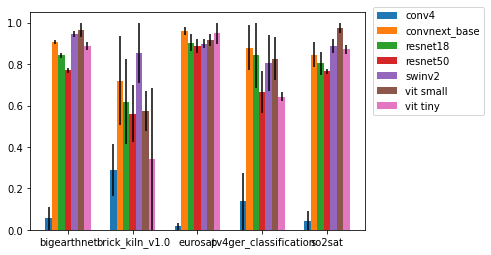

In [9]:
colors = cm.rainbow(np.linspace(0, 1, 7))

normalizer = Normalizer(df_mean, df_std)
for i, backbone in enumerate(df_mean):
    print(backbone)
    ds_names = df_mean[backbone].keys()
    mean = normalizer.from_row(df_mean[backbone])
    err = normalizer.from_row(df_std[backbone], scale_only=True)
    x = np.arange(len(mean)) + i/10 

    if i == 3:
        plt.bar(x, mean, width=0.1, label=backbone, yerr=err,tick_label=ds_names)
    else:
        plt.bar(x, mean, width=0.1, label=backbone, yerr=err, )
plt.legend(bbox_to_anchor=(1.01, 1.05))